In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba
import coffea.hist as hist

In [2]:
infile = "data/signal/wza_UL18_sum.root"
year='2018'

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',    # Recomended
        ]
    }

In [5]:
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
    {
                "x":vec.x,
                "y":vec.y,
                "z":vec.z,
                "t":vec.t
    },
    with_name = "LorentzVector"
    )
    return vec

def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
    {
         "pt": vec.pt,
         "eta": vec.eta,
         "phi": vec.phi,
         "mass": vec.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
    )

    return vec


# << Sort by PT  helper function >>
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [6]:
@numba.njit ## Numba compile -- Boost!
def PhotonVID(vid, idBit):
    rBit = 0
    for x in range(0, 7):
        rBit |= (1 << x) if ((vid >> (x * 2)) & 0b11 >= idBit) else 0
    return rBit


@numba.njit ## Numba compile -- Boost!
def make_fake_obj_mask(Pho,builder):

    #for eventIdx,pho in enumerate(tqdm(Pho)):   # --Event Loop
    for eventIdx,pho in enumerate(Pho):
        builder.begin_list()
        if len(pho) < 1: continue;
    
            
        for phoIdx,_ in enumerate(pho):# --Photon Loop
        
            vid = Pho[eventIdx][phoIdx].vidNestedWPBitmap
            vid_cuts1 = PhotonVID(vid,1) # Loose photon
            vid_cuts2 = PhotonVID(vid,2) # Medium photon
            vid_cuts3 = PhotonVID(vid,3) # Tight photon

            # Field name
            # |0|0|0|0|0|0|0| 
            # |IsoPho|IsoNeu|IsoChg|Sieie|hoe|scEta|PT|

            # 1. Turn off cut (ex turn off Sieie
            # |1|1|1|0|1|1|1| = |1|1|1|0|1|1|1|

            # 2. Inverse cut (ex inverse Sieie)
            # |1|1|1|1|1|1|1| = |1|1|1|0|1|1|1|

            
                
            #if (vid_cuts2 & 0b1111111 == 0b1111111): # Cut applied
            #if (vid_cuts2 & 0b1111111 == 0b1110111): # Inverse Sieie
            if (vid_cuts2 & 0b1100111 == 0b1100111): # Without Sieie & IsoChg
                builder.boolean(True)
            else:
                builder.boolean(False)

        builder.end_list()
                
    return builder

# - Sieie-> EB: 0.01015 EE: 0.0272 

In [7]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

# Sort particle order by PT  # RunD --> has problem
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

Initial_events = events
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]

cut1 = np.ones(len(events))
# Particle Identification
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
Jet = events.Jet
MET = events.MET

In [8]:
print("#### 0. Trigger: {0} -> {1}".format(len(Initial_events), len(events)))

#### 0. Trigger: 128000 -> 22276


### -  Gen_Photon for dR

In [9]:
genparts = events.GenPart

In [10]:
pdgID_mask = (genparts.pdgId == 22)

In [11]:
# mask2: isPrompt | fromHardProcess | isLastCopy
# isLastCopy: Final passing photon 
mask2 = (1 << 0) | (1 << 8) | (1 << 13)

# https://github.com/PKUHEPEWK/WGamma/blob/master/2018/wgRealPhotonTemplateModule.py

status_mask = ((genparts.statusFlags & mask2) == mask2 )

In [12]:
gen_photons  = genparts[pdgID_mask & status_mask]

In [13]:
assert( ak.all(ak.num(gen_photons) == 1))

In [14]:
len(gen_photons)

22276

### - Muon for dR

In [15]:
#  --Muon ( only used to calculate dR )
MuSelmask = (Muon.pt >= 10) & (abs(Muon.eta) <= 2.5)  & (Muon.tightId) & (Muon.pfRelIso04_all < 0.15)
#Muon = ak.mask(Muon,MuSelmask)
Muon = Muon[MuSelmask]

### 1. Electron Selection

In [16]:
##----------- Cut flow2: Electron Selection

EleSelmask = ((Electron.pt >= 10) & (np.abs(Electron.eta + Electron.deltaEtaSC) < 1.479)  &  (Electron.cutBased > 2) & (abs(Electron.dxy) < 0.05) & (abs(Electron.dz) < 0.1)) | \
            ((Electron.pt >= 10) & (np.abs(Electron.eta + Electron.deltaEtaSC) > 1.479) & (np.abs(Electron.eta + Electron.deltaEtaSC) <= 2.5) & (Electron.cutBased > 2) & (abs(Electron.dxy) < 0.1) & (abs(Electron.dz) < 0.2))

Electron = Electron[EleSelmask]

# apply cut 2
Tri_electron_mask = ak.num(Electron) >= 2
Electron = Electron[Tri_electron_mask]
Photon = Photon[Tri_electron_mask]
Jet = Jet[Tri_electron_mask]
MET = MET[Tri_electron_mask]
Muon = Muon[Tri_electron_mask]
gen_photons = gen_photons[Tri_electron_mask]

cut2 = np.ones(len(Photon)) * 2

In [17]:
print(len(Photon))
print(len(gen_photons))

13794
13794


## 2. Photon Selection

In [18]:
# Basic photon selection
isgap_mask = (abs(Photon.eta) < 1.442)  |  ((abs(Photon.eta) > 1.566) & (abs(Photon.eta) < 2.5))
Pixel_seed_mask = ~Photon.pixelSeed
PT_mask = Photon.pt >= 20
Photon_template_mask = make_fake_obj_mask(Photon, ak.ArrayBuilder()).snapshot()


# dR cut with selected Muon and Electrons
dr_pho_ele_mask = ak.all(Photon.metric_table(Electron) >= 0.5, axis=-1) # default metric table: delta_r
dr_pho_mu_mask = ak.all(Photon.metric_table(Muon) >= 0.5, axis=-1)

/home/jkim/miniconda3/envs/pyHEP/lib/python3.8/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()


In [19]:
PhoSelmask = PT_mask  & isgap_mask &  Pixel_seed_mask & dr_pho_ele_mask & dr_pho_mu_mask & Photon_template_mask
Photon = Photon[PhoSelmask]

In [20]:
# Apply cut 3
A_photon_mask = ak.num(Photon)  >=1
Electron = Electron[A_photon_mask ]
Photon   = Photon[A_photon_mask]
Jet = Jet[A_photon_mask]
Muon = Muon[A_photon_mask]
MET = MET[A_photon_mask]
gen_photons = gen_photons[A_photon_mask]

In [21]:
print(len(Photon))
print(len(gen_photons))

5343
5343


## 3. Photon Gen-Reco matching

In [22]:
pair = ak.cartesian({"pho": Photon, "gen_pho": gen_photons}, nested=True)

In [23]:
dR_pho_phogen =  pair.pho.delta_r(pair.gen_pho)

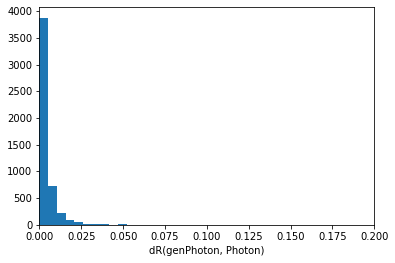

In [24]:
plt.hist(ak.flatten(ak.flatten(dR_pho_phogen)),bins=1000)
plt.xlim(0,0.2)
plt.xlabel('dR(genPhoton, Photon)')
#plt.yscale('log')
plt.show()

In [25]:
gen_match_photon_mask  = ak.firsts(ak.all(dR_pho_phogen <= 0.1,axis=-1))

In [26]:
Photon = Photon[gen_match_photon_mask]

In [27]:
gen_match_photon_evt_mask = ak.num(Photon) >= 1

Electron = Electron[gen_match_photon_evt_mask]
Photon   = Photon[gen_match_photon_evt_mask]
Jet = Jet[gen_match_photon_evt_mask]
MET = MET[gen_match_photon_evt_mask]
gen_photons = gen_photons[gen_match_photon_evt_mask]
print(len(Photon))

4952


### 2. Select OSSF electron pairs

In [28]:
##-----------  Cut flow3: Electron Selection --> OSSF 
# OSSF index maker
@numba.njit
def find_2lep(events_leptons,builder):
    for leptons in events_leptons:

        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0+1,nlep):
                if leptons[i0].charge + leptons[i1].charge != 0: continue;
                
                if nlep == 2:
                    builder.begin_tuple(2)
                    builder.index(0).integer(i0)
                    builder.index(1).integer(i1)
                    builder.end_tuple()  

            
                else:
                    for i2 in range(nlep):
                        if len({i0,i1,i2}) < 3: continue;
                        builder.begin_tuple(3)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.end_tuple()
        builder.end_list()
    return builder

In [29]:
ossf_idx = find_2lep(Electron,ak.ArrayBuilder()).snapshot()
ossf_idx

<Array [[(0, 1, 2), (0, 2, 1, ... )], [(0, 1)]] type='4952 * var * union[(int64,...'>

In [30]:
# OSSF cut
ossf_mask = ak.num(ossf_idx) >= 1
ossf_idx = ossf_idx[ossf_mask]

Electron= Electron[ossf_mask]
Photon= Photon[ossf_mask]
Jet= Jet[ossf_mask]
MET = MET[ossf_mask]

In [31]:
print("#### 2. OSSF {0}".format(len(Photon)))

#### 2. OSSF 3862


In [32]:
Double_electron = [Electron[ossf_idx[idx]] for idx in "01"]

Diele    = ak.zip({"lep1":Double_electron[0],
                   "lep2":Double_electron[1],
                     "p4":TLorentz_vector(Double_electron[0]+Double_electron[1])})
bestZ_idx = ak.singletons(ak.argmin(abs(Diele.p4.mass - 91.1876), axis=1))
Diele = Diele[bestZ_idx]

leading_ele, subleading_ele  = ak.flatten(TLorentz_vector_cylinder(Diele.lep1)),ak.flatten(TLorentz_vector_cylinder(Diele.lep2))

In [33]:
def make_bins(pt,eta,sieie,bin_range_str):

        bin_dict = {'PT_1_eta_1' : ( pt > 20 ) & ( pt < 30 ) & ( eta < 1) 
        ,'PT_1_eta_2' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_1_eta_3' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_1_eta_4' : ( pt > 20 ) & ( pt < 30 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_2_eta_1' : ( pt > 30 ) & ( pt < 40 ) & ( eta < 1) 
        ,'PT_2_eta_2' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_2_eta_3' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_2_eta_4' : ( pt > 30 ) & ( pt < 40 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_3_eta_1' : ( pt > 40 ) & ( pt < 50 ) & ( eta < 1) 
        ,'PT_3_eta_2' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_3_eta_3' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_3_eta_4' : ( pt > 40 ) & ( pt < 50 ) & ( eta > 2) & ( eta < 2.5 )

        ,'PT_4_eta_1' :  ( pt > 50 ) & ( eta < 1) 
        ,'PT_4_eta_2' :  ( pt > 50 ) & ( eta > 1) & ( eta < 1.5 )
        ,'PT_4_eta_3' :  ( pt > 50 ) & ( eta > 1.5) & ( eta < 2 )
        ,'PT_4_eta_4' :  ( pt > 50 ) & ( eta > 2) & ( eta < 2.5 )
        }
    
        binmask = bin_dict[bin_range_str]
        
        return ak.to_numpy(sieie[binmask])

In [34]:
photon = Photon[:,0]

In [35]:
bin_name_list = ['PT_1_eta_1' ,'PT_1_eta_2' ,'PT_1_eta_3' ,'PT_1_eta_4' 
                 ,'PT_2_eta_1' ,'PT_2_eta_2' ,'PT_2_eta_3' ,'PT_2_eta_4' ,'PT_3_eta_1' ,'PT_3_eta_2' 
                 ,'PT_3_eta_3' ,'PT_3_eta_4' ,'PT_4_eta_1' ,'PT_4_eta_2' ,'PT_4_eta_3' ,'PT_4_eta_4']

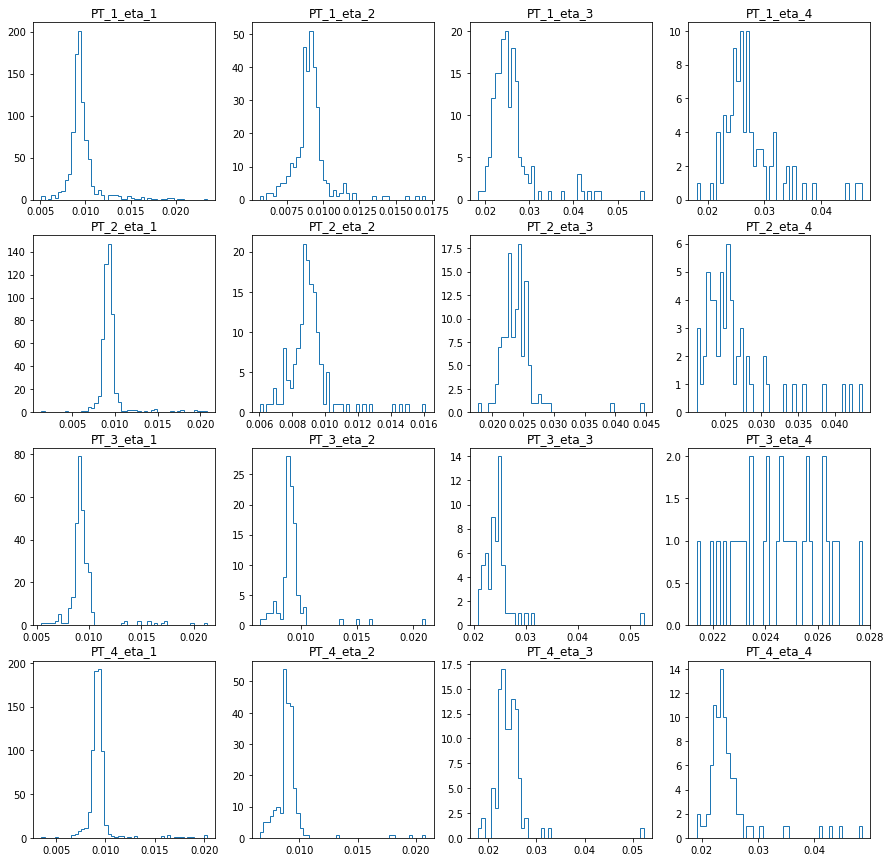

In [36]:
fig,axs = plt.subplots(4,4,figsize=(15,15))
axs = axs.ravel()

for ith,name in enumerate(bin_name_list):
    
    axs[ith].hist(make_bins(photon.pt,abs(photon.eta),photon.sieie,name),bins=50,histtype='step')
    axs[ith].set_title(name)

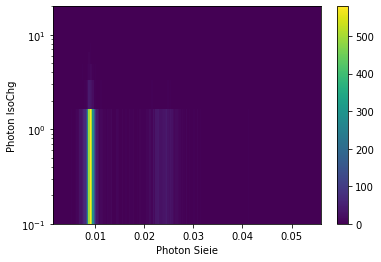

In [37]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

sieie = ak.to_numpy(ak.flatten(Photon.sieie))
Isochg = ak.to_numpy(ak.flatten(Photon.pfRelIso03_chg * Photon.pt))


h = ax.hist2d(sieie,Isochg,bins=(200,100))
plt.xlabel('Photon Sieie')
plt.ylim(0.1,20)
plt.yscale('log')
plt.ylabel('Photon IsoChg')
fig.colorbar(h[3],ax=ax)
plt.show()

---

In [38]:
leading_pho = Photon[:,0]

### 5. Event Selection

In [39]:
##-----------  Cut flow5 and 6: Event Selection

# Z mass window
zmass_window_mask = ak.firsts((Diele.p4.mass) > 4)

# PT mask
Elept_mask = ak.firsts((Diele.lep1.pt >= 25) & (Diele.lep2.pt >=10))

# MET mask
MET_mask = MET.pt > 20


# Event selection mask
Event_sel_mask   = zmass_window_mask & Elept_mask & MET_mask


# Apply cuts
Diele_sel   = Diele[Event_sel_mask]
leading_pho_sel   = leading_pho[Event_sel_mask]
# Photon  EE and EB

isEE_mask = leading_pho.isScEtaEE
isEB_mask = leading_pho.isScEtaEB
Pho_EE = leading_pho[isEE_mask & Event_sel_mask]
Pho_EB = leading_pho[isEB_mask & Event_sel_mask]
MET_sel           = MET[Event_sel_mask]

In [40]:
print("#### 5. Event selection: {0}".format(len(Diele_sel)))

#### 5. Event selection: 3495


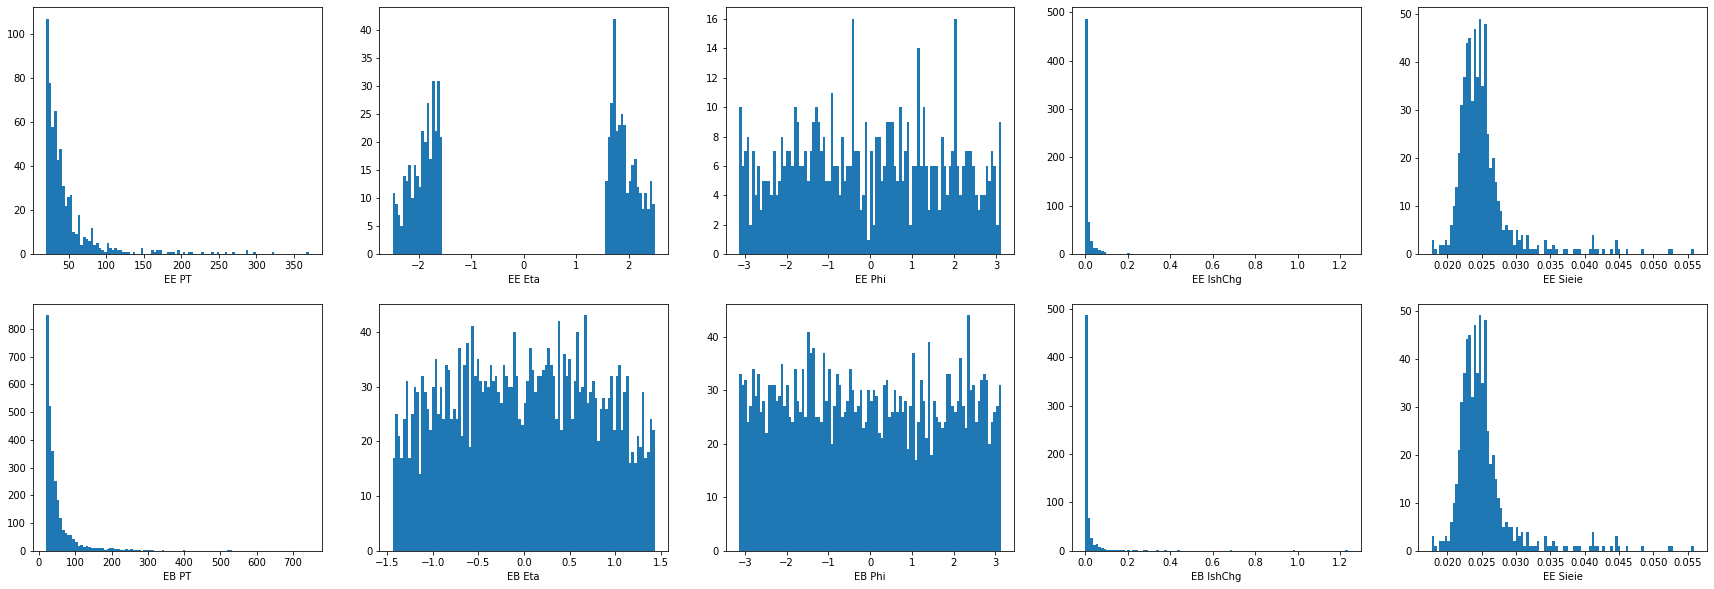

In [41]:
Pho_EE_pt     = Pho_EE.pt
Pho_EE_eta    = Pho_EE.eta
Pho_EE_phi    = Pho_EE.phi
Pho_EE_Isochg = Pho_EE.pfRelIso03_chg
Pho_EE_Sieie  = Pho_EE.sieie


Pho_EB_pt  = Pho_EB.pt
Pho_EB_eta = Pho_EB.eta
Pho_EB_phi = Pho_EB.phi
Pho_EB_Isochg = Pho_EE.pfRelIso03_chg
Pho_EB_Sieie  = Pho_EE.sieie


Diele_mass = ak.flatten(Diele_sel.p4.mass)
eeg_vec = Diele_sel.p4 + leading_pho_sel
eeg_mass = ak.flatten(eeg_vec.mass)

Ele1_pt  = ak.flatten(Diele_sel.lep1.pt)
Ele1_eta = ak.flatten(Diele_sel.lep1.eta)
Ele1_phi = ak.flatten(Diele_sel.lep1.phi)

Ele2_pt  = ak.flatten(Diele_sel.lep2.pt)
Ele2_eta = ak.flatten(Diele_sel.lep2.eta)
Ele2_phi = ak.flatten(Diele_sel.lep2.phi)
fig,axs = plt.subplots(2,5,figsize=(30,10))
bins=100

axs[0,0].hist(Pho_EE_pt,bins=bins)
axs[0,0].set_xlabel('EE PT')
axs[0,1].hist(Pho_EE_eta,bins=bins)
axs[0,1].set_xlabel('EE Eta')
axs[0,2].hist(Pho_EE_phi,bins=bins)
axs[0,2].set_xlabel('EE Phi')
axs[0,3].hist(Pho_EE_Isochg,bins=bins)
axs[0,3].set_xlabel('EE IshChg')
axs[0,4].hist(Pho_EE_Sieie,bins=bins)
axs[0,4].set_xlabel('EE Sieie')

axs[1,0].hist(Pho_EB_pt,bins=bins)
axs[1,0].set_xlabel('EB PT')
axs[1,1].hist(Pho_EB_eta,bins=bins)
axs[1,1].set_xlabel('EB Eta')
axs[1,2].hist(Pho_EB_phi,bins=bins)
axs[1,2].set_xlabel('EB Phi')
axs[1,3].hist(Pho_EB_Isochg,bins=bins)
axs[1,3].set_xlabel('EB IshChg')
axs[1,4].hist(Pho_EB_Sieie,bins=bins)
axs[1,4].set_xlabel('EE Sieie')
plt.show()

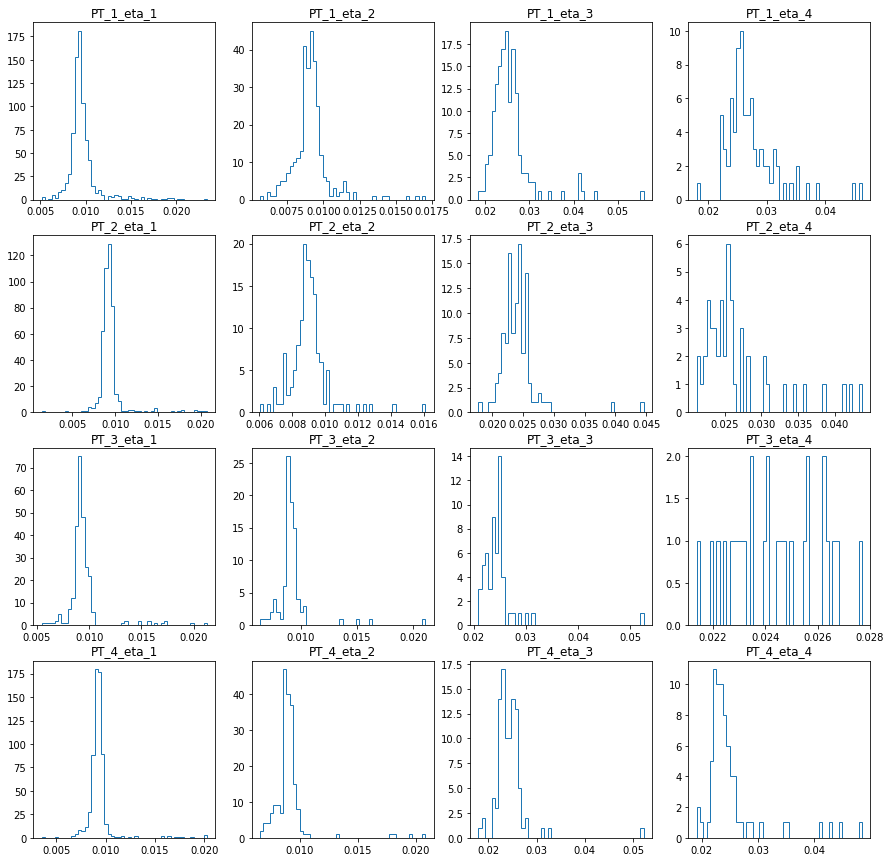

In [42]:
fig,axs = plt.subplots(4,4,figsize=(15,15))
axs = axs.ravel()

for ith,name in enumerate(bin_name_list):
    
    axs[ith].hist(make_bins(leading_pho_sel.pt,abs(leading_pho_sel.eta),leading_pho_sel.sieie,name),bins=50,histtype='step')
    axs[ith].set_title(name)